# Chess.com club member analysis

This python code does the following:
1: Collects rapid and blitz stats about team members for one club on chess.com
2: Saves them into three csv files: all members, rapid members, blitz members
3: For rapid members and blitz members respectively, historical games are collected, with focus on stronger and frequent players as well as weekdays and hours of games. The games are all the games played, not just team matches.

This can be useful for club admins. Thank you to chess.com api and developer community which can be found through this link: https://www.chess.com/club/chess-com-developer-community

The purpose is to analyse the number of active players in a chess.com club, their ratings, when they played the last game, and what days and hours they play, all with the goal to use these data to grow the club. / 

In [1]:
# Import libs

import pandas as pd
import numpy as np
import json
import urllib.request
from datetime import datetime
import matplotlib.pyplot as plt
import pytz #time zone

In [2]:
team = 'team-denmark' # change to team as required

In [3]:
# Read the stats for all members of a team.

url = "https://api.chess.com/pub/club/{0}/members".format(team)
data = urllib.request.urlopen(url)
data = json.loads(data.read().decode())

In [4]:
# Split into activity level, because the json file is structured in three parts. 
all_time = data["all_time"]
monthly = data["monthly"]
weekly  = data["weekly"]

# Get all members into one list, because I am not really interested in the activity level.

members = []

for n in all_time:
    member = n["username"]
    members.append(member)

for n in monthly:
    member = n["username"]
    members.append(member)

for n in weekly:
    member = n["username"]
    members.append(member)

In [7]:
# Stats about blitz and rapid is parsed for all team members.
# I could add Daily, Bullet, etc, but I don't need that information, so for now I'll stick to rapid and blitz.

# Lists are initiated. In the following for loops, they are used to append data.
rapid_ratingL = []
rapid_dateL = []
rapid_winL = []
rapid_lossL = []
rapid_drawL = []
blitz_ratingL = []
blitz_dateL = []
blitz_winL = []
blitz_lossL = []
blitz_drawL = []

# Used in the for loop counter
f = 0
members_count = len(members)

# For loop parsing stats about team members. One team member at a time.
for n in members:
    with urllib.request.urlopen("https://api.chess.com/pub/player/{0}/stats".format(n)) as url:
        
        # The parsed file is json format 
        data = json.loads(url.read().decode())
        
        # Try/except is used because not all members have stats about all elements
        try:
            rapid_rating = data["chess_rapid"]['last']['rating']
        except:
            rapid_rating = 0
        rapid_ratingL.append(rapid_rating)

        try:
            rapid_date = data["chess_rapid"]['last']['date']
        except:
            rapid_date = 0
        rapid_dateL.append(rapid_date)

        try:
            rapid_win = data["chess_rapid"]['record']['win']
        except:
            rapid_win = 0
        rapid_winL.append(rapid_win)

        try:
            rapid_loss = data["chess_rapid"]['record']['loss']
        except:
            rapid_loss = 0
        rapid_lossL.append(rapid_loss)

        try:
            rapid_draw = data["chess_rapid"]['record']['draw']
        except:
            rapid_draw = 0
        rapid_drawL.append(rapid_draw)

        try:
            blitz_rating = data["chess_blitz"]['last']['rating']
        except:    
            blitz_rating = 0
        blitz_ratingL.append(blitz_rating)

        try:
            blitz_date = data["chess_blitz"]['last']['date']
        except:
            blitz_date = 0
        blitz_dateL.append(blitz_date)

        try:
            blitz_win = data["chess_blitz"]['record']['win']
        except:
            blitz_win = 0
        blitz_winL.append(blitz_win)

        try:
            blitz_loss = data["chess_blitz"]['record']['loss']
        except:    
            blitz_loss = 0
        blitz_lossL.append(blitz_loss)

        try:
            blitz_draw = data["chess_blitz"]['record']['draw']
        except:
            blitz_draw = 0
        blitz_drawL.append(blitz_draw)
        
        # For loop counter
        f = f + 1
        print(str(f) + " of " + str(members_count), end="\r")
        
# The timestamps is translated to something humans can read

rapid_timestamp = []

for n in rapid_dateL:
    date = datetime.utcfromtimestamp(n).strftime('%d-%m-%Y')
    rapid_timestamp.append(date)

blitz_timestamp = []

for n in blitz_dateL:
    date = datetime.utcfromtimestamp(n).strftime('%d-%m-%Y')
    blitz_timestamp.append(date)

In [8]:
# All the parsed data is consolidated into one pandas dataframe and calculations about "days since last game" is done

member_file = list(zip(members,rapid_ratingL,rapid_timestamp,rapid_winL,rapid_lossL,rapid_drawL,blitz_ratingL,blitz_timestamp,blitz_winL,
                  blitz_lossL,blitz_drawL))

member_file = pd.DataFrame(member_file)

# rename column names
member_file.columns = ['username', 'rapid_rating', 'rapid_timestamp','rapid_win','rapid_loss','rapid_draw','blitz_rating','blitz_timestamp','blitz_win',
                  'blitz_loss','blitz_draw']

# change date columns to time format
member_file['rapid_timestamp'] = pd.to_datetime(member_file['rapid_timestamp'], format='%d-%m-%Y')
member_file['blitz_timestamp'] = pd.to_datetime(member_file['blitz_timestamp'], format='%d-%m-%Y')

# Calculate number of "days since last game". This is used to determine whether the player is a recent player,
# because some players "disapear" from chess.com and we cannot expect them to be part of our games
member_file['rapid_days_since_last_game'] = member_file['rapid_timestamp'] - pd.Timestamp.now().normalize()
member_file['blitz_days_since_last_game'] = member_file['blitz_timestamp'] - pd.Timestamp.now().normalize()
member_file['rapid_days_since_last_game'] = -(member_file['rapid_days_since_last_game'].dt.days)
member_file['blitz_days_since_last_game'] = -(member_file['blitz_days_since_last_game'].dt.days)

# Rearrange columns to make it more logic
member_file = member_file[['username', 'rapid_days_since_last_game', 'rapid_timestamp','rapid_rating','rapid_win','rapid_loss','rapid_draw','blitz_days_since_last_game','blitz_timestamp','blitz_rating','blitz_win',
                  'blitz_loss','blitz_draw']]

In [9]:
# The rapid players are filtered, because I will parse the players games. As this is very time consuming and heavy for chess.com,
#I'll filter for most important players first. The chosen filters reduces the players to about 100 of the 1580 members.

# Max number of days since last rapid game. 60 days has been chosen, even though 60 days since last game is long,
# but another filtering can be done later on. 
members_rapid = member_file[member_file['rapid_days_since_last_game'] <= 60 ] # change number as desired

# Current minimum rapid rating. Based on my experience, our 5th board is about 1400 (when we have a strong team),
# and the key to be a stronger team is the strongest players, so for now the limit to the analysis is around 1400. 
members_rapid = members_rapid[members_rapid['rapid_rating'] >= 1300 ] # change number as desired

In [30]:
# The blitz players are filtered

# Max number of days since last blitz game. Same as for rapid. Could be lower because blitz games are much more
# frequent, so we'll get enough data even with 20 days.
members_blitz = member_file[member_file['blitz_days_since_last_game'] <= 20 ] # change number as desired

# Current minimum blitz rating. Same as for rapid.
members_blitz = members_blitz[members_blitz['blitz_rating'] >= 1500 ] # change number as desired

In [31]:
# Three csv files are created. This step saves time later on, because the initial parsing takes time,
# and therefore saving to csv files ensures that we don't have to do the parsings again.

member_file.to_csv(team + '_member_file.csv', sep='|') # all members #change
members_blitz.to_csv(team + '_members_blitz.csv', sep='|') # members according to rapid filters #change
members_rapid.to_csv(team + '_members_rapid.csv', sep='|') # members according to blitz filters #change

## Game data for the selected rapid players 

The next step is to extract games for the selected rapid players, then extract date and time for games, gather all data nice and neatly in one csv file.

In [12]:
# Read the rapid csv file created before
members_rapid = pd.read_csv(team + '_members_rapid.csv', sep='|') #change

In [13]:
# Make a list of rapid usernames. The list will be used in the for loops.
users_rapid = list(members_rapid['username'])

In [14]:
# Parse historical games for each rapid member.

# The years and months you want to parse. I recommend to select only one year and max three months, because of parsing time.
years = ['2019']
months = ['07','08','09','10','11']

time = []
time_class = []
users = []

# Used in the for loop counter
f = 0
members_count = len(users_rapid)
g = 0

for u in users_rapid:
    # For loop counter
    f = f + 1
    print(str(f) + " of " + str(members_count) + " users are parsed.", end="\r")
    
    for y in years:
        for m in months:
            games = urllib.request.urlopen("https://api.chess.com/pub/player/{0}/games/{1}/{2}".format(u, y, m))
            games = json.loads(games.read().decode())
            games = games['games']

            for n in games:
                t = n['end_time']
                c = n['time_class']
                time.append(t)
                time_class.append(c)
                users.append(u)
                
                # For loop counter
                g = g + 1
                print(str(g) + " games are parsed.", end="\r")




In [17]:
# The timestamp is translated to human readble dates, and the day and hour of play is extracted.

games_time = []
games_hour = []
games_day = []

pst = pytz.timezone('Europe/Vienna') # change time zone 
utc = pytz.utc
fmt = '%Y-%m-%d %H:%M:%S %Z%z'

for n in time:
    date = utc.localize(datetime.utcfromtimestamp(n))
    date.strftime(fmt)
    date_pst = date.astimezone(pst)
    date_pst = date_pst.strftime('%d-%m-%Y')
    games_time.append(date_pst)

for n in time:
    hour = utc.localize(datetime.utcfromtimestamp(n))
    hour.strftime(fmt)
    hour_pst = hour.astimezone(pst)
    hour_pst = hour_pst.strftime('%H')
    games_hour.append(hour_pst)

for n in time:
    day = utc.localize(datetime.utcfromtimestamp(n))
    day.strftime(fmt)
    day_pst = day.astimezone(pst)
    day_pst = day_pst.strftime('%A')
    games_day.append(day_pst)

    
rapid_games = list(zip(users, time_class, time, games_time, games_day, games_hour))
rapid_games = pd.DataFrame(rapid_games)
rapid_games.columns = ['username','time_class','timestamp', 'rapid_games_time' , 'day','hour']
rapid_games = rapid_games[rapid_games['time_class'] == 'rapid']

In [18]:
# rapid games are merged with the stats about rapid players
rapid_games_total = pd.merge(rapid_games,members_rapid, on='username', how='left')

In [19]:
# csv file is created
rapid_games_total.to_csv(team + '_rapid_games.csv', sep='|')

# Game data for blitz players 

I do the exact same thing for blitz. I have seperated rapid and blitz, because the parsing takes time, and this makes it easy to make seperate parsings, as required.

In [32]:
# Read the blitz csv file
members_blitz = pd.read_csv(team + '_members_blitz.csv', sep='|')

In [33]:
# Make a list of blitz usernames. The list will be used in the for loops.
users_blitz = list(members_blitz['username'])

In [35]:
# Parse historical games for each blitz member.

# The years and months you want to parse. I recommend to select only one year and max three months, because of parsing time.
years = ['2019']
months = ['09','10','11']

time = []
time_class = []
users = []

# Used in the for loop counter
f = 0
members_count = len(users_blitz)
g = 0

for u in users_blitz:
    # For loop counter
    f = f + 1
    print(str(f) + " of " + str(members_count) + " users are parsed.", end="\r")
    
    for y in years:
        for m in months:
            games = urllib.request.urlopen("https://api.chess.com/pub/player/{0}/games/{1}/{2}".format(u, y, m))
            games = json.loads(games.read().decode())
            games = games['games']

            for n in games:
                t = n['end_time']
                c = n['time_class']
                time.append(t)
                time_class.append(c)
                users.append(u)
                
                # For loop counter
                g = g + 1
                print(str(g) + " games are parsed.", end="\r")


In [36]:
# The timestamp is translated to human readble dates, and the day and hour of play is extracted.

games_time = []
games_hour = []
games_day = []

pst = pytz.timezone('Europe/Vienna')
utc = pytz.utc
fmt = '%Y-%m-%d %H:%M:%S %Z%z'

for n in time:
    date = utc.localize(datetime.utcfromtimestamp(n))
    date.strftime(fmt)
    date_pst = date.astimezone(pst)
    date_pst = date_pst.strftime('%d-%m-%Y')
    games_time.append(date_pst)

for n in time:
    hour = utc.localize(datetime.utcfromtimestamp(n))
    hour.strftime(fmt)
    hour_pst = hour.astimezone(pst)
    hour_pst = hour_pst.strftime('%H')
    games_hour.append(hour_pst)

for n in time:
    day = utc.localize(datetime.utcfromtimestamp(n))
    day.strftime(fmt)
    day_pst = day.astimezone(pst)
    day_pst = day_pst.strftime('%A')
    games_day.append(day_pst)

    
blitz_games = list(zip(users, time_class, time, games_time, games_day, games_hour))
blitz_games = pd.DataFrame(blitz_games)
blitz_games.columns = ['username','time_class','timestamp', 'blitz_games_time' , 'day','hour']
blitz_games = blitz_games[blitz_games['time_class'] == 'blitz']

In [37]:
# blitz games are merged with the stats about blitz players
blitz_games_total = pd.merge(blitz_games,members_blitz, on='username', how='left')

In [38]:
# csv file is created
blitz_games_total.to_csv(team + '_blitz_games.csv', sep='|')

## Analyse club members

In [39]:
# Read the member csv file created before
member_file = pd.read_csv(team + '_member_file.csv', sep='|') #change
member_file['rapid_games'] = member_file['rapid_win'] + member_file['rapid_loss'] + member_file['rapid_draw']
member_file['blitz_games'] = member_file['blitz_win'] + member_file['blitz_loss'] + member_file['blitz_draw']
member_stats = member_file[['username','rapid_games','rapid_rating','rapid_days_since_last_game','blitz_games','blitz_rating','blitz_days_since_last_game']]

              rapid_rating  blitz_rating
rapid_rating      1.000000      0.712877
blitz_rating      0.712877      1.000000


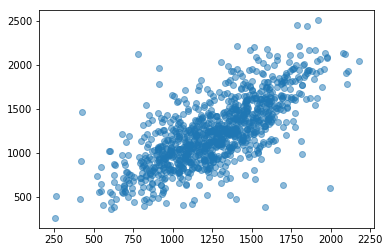

In [40]:
blitz_rapid = member_stats[(member_stats['rapid_games'] > 0) & (member_stats['blitz_games'] > 0)]

blitz_rapid_c = blitz_rapid[['rapid_rating','blitz_rating']]

print(blitz_rapid_c.corr())

x=blitz_rapid['rapid_rating']
y=blitz_rapid['blitz_rating']
plt.scatter(x,y, alpha=0.5)

#color: blitz_rapid, rapid, blitz, none


In [61]:
blitz_all = member_stats[member_stats['blitz_games'] > 0]
rapid_all = member_stats[member_stats['rapid_games'] > 0]

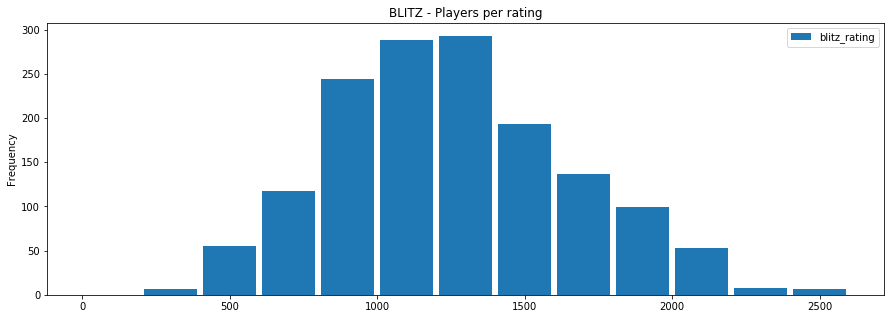

In [63]:
blitz_all[['blitz_rating']].plot(kind='hist', figsize=(15,5), bins=[0,200,400,600,800,1000,1200,1400,1600,1800,2000,2200,2400,2600],
                                 title='BLITZ - Players per rating', rwidth=0.9)

plt.show()

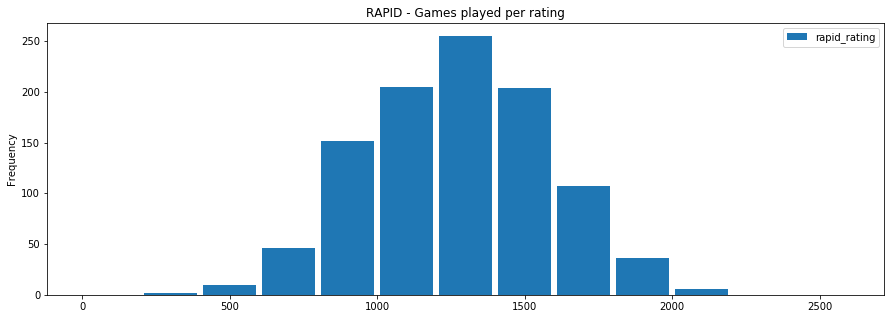

In [60]:
rapid_all[['rapid_rating']].plot(kind='hist', figsize=(15,5), bins=[0,200,400,600,800,1000,1200,1400,1600,1800,2000,2200,2400,2600],
                                 title='RAPID - Games played per rating', rwidth=0.9)

plt.show()

## Rapid players analysis

In [68]:
# Read the rapid games csv file
games_rapid = pd.read_csv(team + '_rapid_games.csv', sep='|')

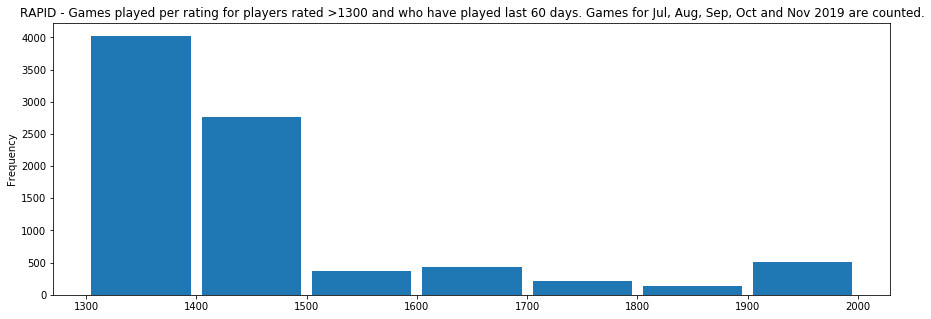

In [89]:
games_rapid['rapid_rating'].plot(kind='hist', figsize=(15,5), title='RAPID - Games played per rating for players rated >1300 and who have played last 60 days. Games for Jul, Aug, Sep, Oct and Nov 2019 are counted.', rwidth=0.9, bins=[1300,1400,1500,1600,1700,1800,1900,2000])

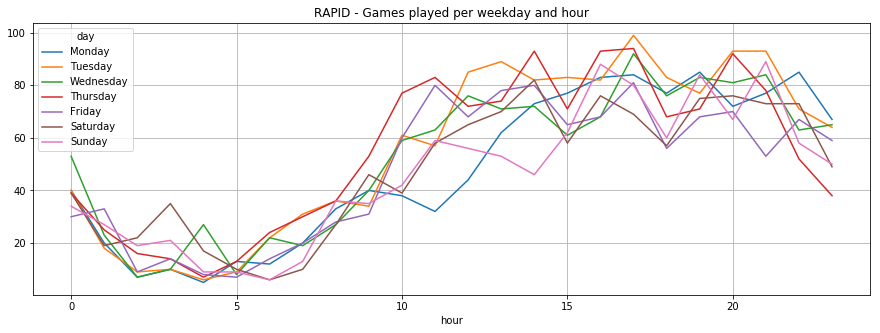

In [103]:
# Games played by day and hour in timezone selected earlier
games_rapid_time = games_rapid.pivot_table(columns='day',index='hour',values='username',aggfunc='count')
games_rapid_time = games_rapid_time[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

games_rapid_time.plot(figsize=(15,5), title='RAPID - Games played per weekday and hour', grid=True)

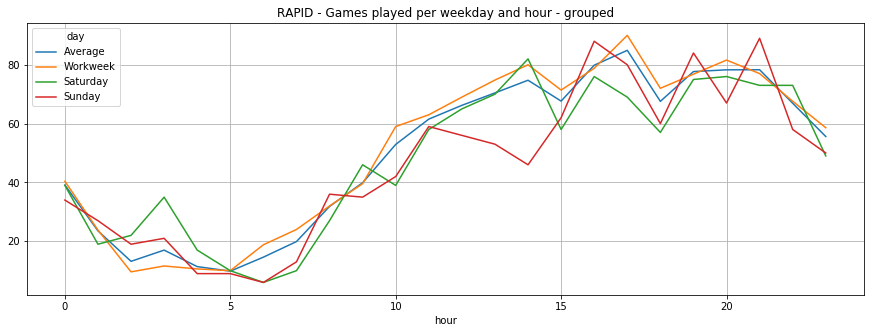

In [101]:
# Games played by day and hour in timezone selected earlier
games_rapid_time['Average'] = games_rapid_time.mean(axis=1)
games_rapid_time['Workweek'] = games_rapid_time[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']].mean(axis=1)
games_rapid_time['Weekend'] = games_rapid_time[['Saturday', 'Sunday']].mean(axis=1)
games_rapid_time_grouped = games_rapid_time[['Average','Workweek','Saturday','Sunday']]
games_rapid_time_grouped.plot(figsize=(15,5), title='RAPID - Games played per weekday and hour - grouped', grid=True)

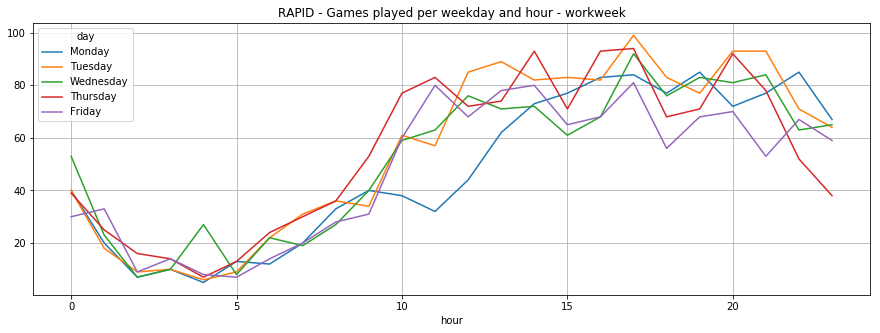

In [105]:
games_rapid_time_workweek = games_rapid_time[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']]
games_rapid_time_workweek.plot(figsize=(15,5), title='RAPID - Games played per weekday and hour - workweek', grid=True)

In [91]:
games_rapid_time['Average'] = games_rapid_time.mean(axis=1)

## Blitz players analysis

In [71]:
# Read the blitz games csv file
games_blitz = pd.read_csv(team + '_blitz_games.csv', sep='|')

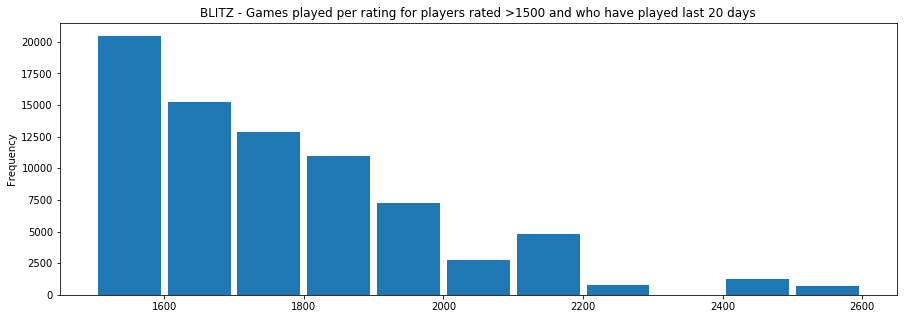

In [88]:


games_blitz['blitz_rating'].plot(kind='hist', figsize=(15,5), title='BLITZ - Games played per rating for players rated >1500 and who have played last 20 days. Games for Sep, Oct and Nov 2019 are counted.', rwidth=0.9, bins=[1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600])

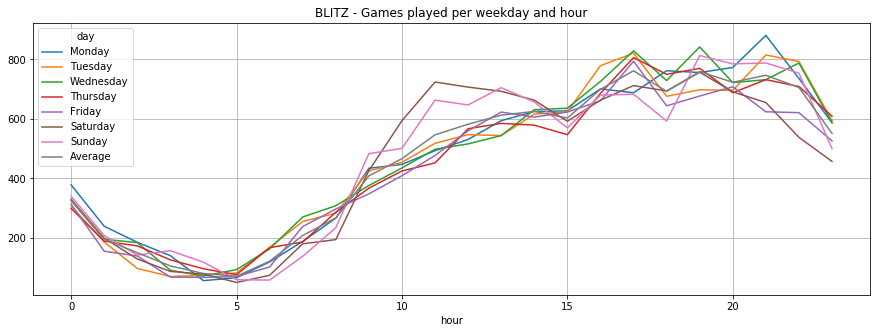

In [107]:
# Games played by day and hour in timezone selected earlier
games_blitz_time = games_blitz.pivot_table(columns='day',index='hour',values='username',aggfunc='count')
games_blitz_time = games_blitz_time[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
games_blitz_time['Average'] = games_blitz_time.mean(axis=1)

games_blitz_time.plot(figsize=(15,5), title='BLITZ - Games played per weekday and hour', grid=True)

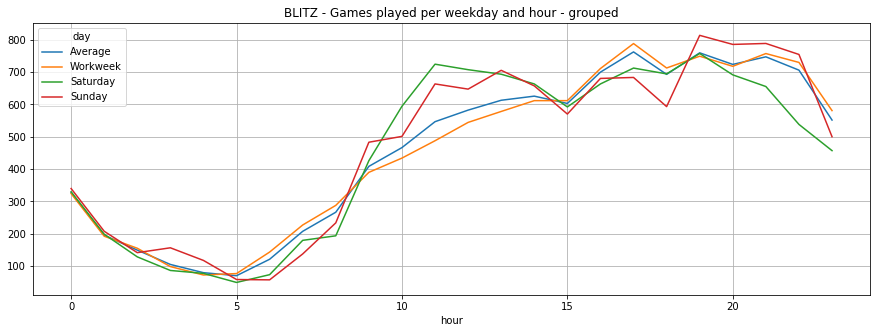

In [108]:
# Games played by day and hour in timezone selected earlier
games_blitz_time['Average'] = games_blitz_time.mean(axis=1)
games_blitz_time['Workweek'] = games_blitz_time[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']].mean(axis=1)
games_blitz_time['Weekend'] = games_blitz_time[['Saturday', 'Sunday']].mean(axis=1)
games_blitz_time_grouped = games_blitz_time[['Average','Workweek','Saturday','Sunday']]
games_blitz_time_grouped.plot(figsize=(15,5), title='BLITZ - Games played per weekday and hour - grouped', grid=True)

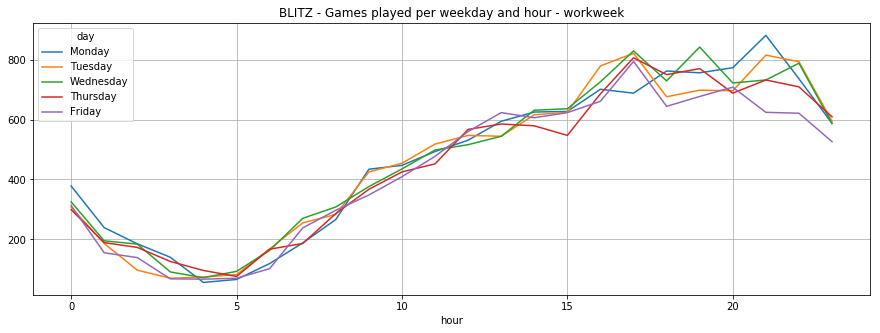

In [106]:
games_blitz_time_workweek = games_blitz_time[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']]
games_blitz_time_workweek.plot(figsize=(15,5), title='BLITZ - Games played per weekday and hour - workweek', grid=True)

The hours with most games played are between 17 and 22, from 23 it starts to decrease, it continues to decrease until the middle of the night and in the early morning it starts to increase slowly until it reaches the peak again between 17 and 22.
Weekends have an early peak from 11 to 17, while saturdays and fridays are lower than other weekdays from 19 to 22.

BEST TIMES TO ORGANIZE LIVE GAMES:
WEEKENDS
19-22 ==> Sunday
11-13 ==> Saturday
17-19 ==> Saturday

WORKWEEK
Not Friday
Not after 22
Not before 17
Monday, Tuesday and Wednesday are better than Thursday